# Using Captum for interpret trained model

I followed a tutorial on captum to get some insight on the trained model: https://captum.ai/tutorials/TorchVision_Interpret



In [1]:
import torch
from torchvision import models, transforms
from PIL import Image
import numpy as np

from captum.attr import IntegratedGradients
from captum.attr import Occlusion
from captum.attr import visualization as viz
from captum.attr import NoiseTunnel
from captum.attr import GradientShap



from matplotlib.colors import LinearSegmentedColormap

labels = ['fresh','blackspot','canker','grenning']
model_file_input = '../models/cross_validation_final.pth'
target_image = '../data/test/blackspot/b (2).jpg'

/usr/local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load Model

Load the model and move to device. 

In [2]:

model = models.mobilenet_v2()
model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, len(labels))
model.load_state_dict(torch.load(model_file_input, weights_only=True))
model = model.eval()

# Load input image

Load the input image that we would like to analyse and transform and normalize it. 

In [3]:
# Load image
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256,256)),
])


# Define image transformations (same as used during training)
transform_normalize = transforms.Compose([
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize images
])

img = Image.open(target_image).convert('RGB')
transformed_img = transform(img)
input = transform_normalize(transformed_img)
input = input.unsqueeze(0)

with torch.no_grad():
    output = model(input)
    output = torch.nn.functional.softmax(output, dim=1)
    prediction_score, pred_label_idx = torch.topk(output, 1)

pred_label_idx.squeeze_()
predicted_label = labels[pred_label_idx.item()]
print('Predicted:', predicted_label, '(', prediction_score.squeeze().item(), ')')



Predicted: blackspot ( 0.9999969005584717 )


## Visualize gradient-based attribution

Here, the integrated gradients are calculated and visualized. The integrated gradients compute the integral of the gradients of the predicted class output to the input image pixels.

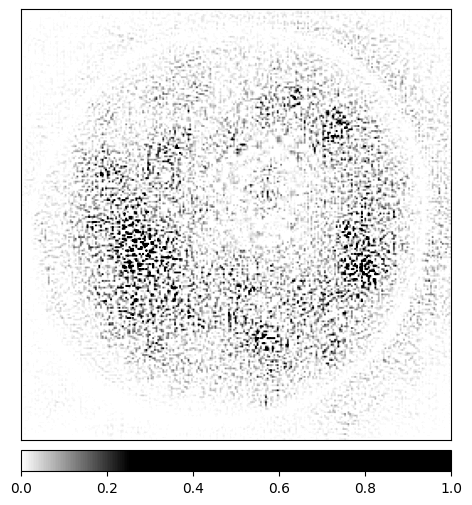

In [4]:

integrated_gradients = IntegratedGradients(model)
attributions_ig = integrated_gradients.attribute(input, target=pred_label_idx, n_steps=200)

default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)

_ = viz.visualize_image_attr(np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap=default_cmap,
                             show_colorbar=True,
                             sign='positive',
                             outlier_perc=1)

noise_tunnel = NoiseTunnel(integrated_gradients)

## For this part the kernel crashed

# attributions_ig_nt = noise_tunnel.attribute(input, nt_samples=10, nt_type='smoothgrad_sq', target=pred_label_idx)
# _ = viz.visualize_image_attr_multiple(np.transpose(attributions_ig_nt.squeeze().cpu().detach().numpy(), (1,2,0)),
#                                       np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
#                                       ["original_image", "heat_map"],
#                                       ["all", "positive"],
#                                       cmap=default_cmap,
#                                       show_colorbar=True)

# torch.manual_seed(0)
# np.random.seed(0)

# gradient_shap = GradientShap(model)

# # Defining baseline distribution of images
# rand_img_dist = torch.cat([input * 0, input * 1])

# attributions_gs = gradient_shap.attribute(input,
#                                           n_samples=50,
#                                           stdevs=0.0001,
#                                           baselines=rand_img_dist,
#                                           target=pred_label_idx)
# _ = viz.visualize_image_attr_multiple(np.transpose(attributions_gs.squeeze().cpu().detach().numpy(), (1,2,0)),
#                                       np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
#                                       ["original_image", "heat_map"],
#                                       ["all", "absolute_value"],
#                                       cmap=default_cmap,
#                                       show_colorbar=True)


## Occlusion-based attribution

In this part another method, called occlusion-based attribution, is used to estimate which part of the image contributed to the decision made. 

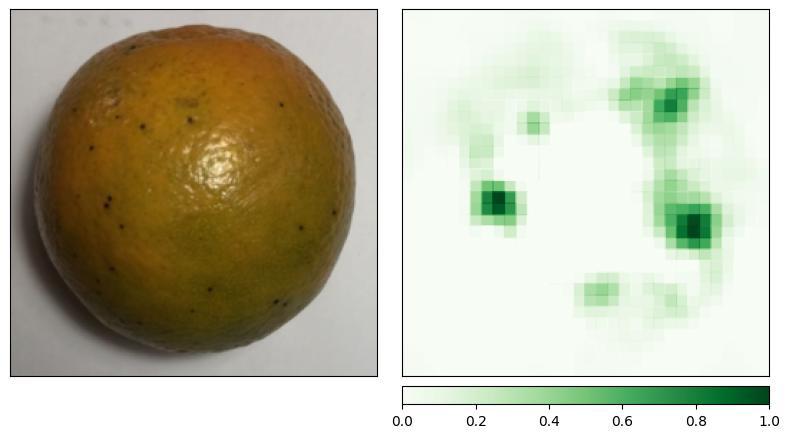

In [5]:
occlusion = Occlusion(model)

attributions_occ = occlusion.attribute(input,
                                       strides = (3, 8, 8),
                                       target=pred_label_idx,
                                       sliding_window_shapes=(3,15, 15),
                                       baselines=0)

_ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2)

The black dots on the left and right of the orange seem to have most impact on the decision this orange has the blackspot disease.